**Exercise:**
In this lab, you will select a dataset for multiple classification and apply all the details of this notebook.


[Logistic regression](https://en.wikipedia.org/wiki/Logistic_regression) is similar to [linear regression](/blog/ml-linear-regression/), but instead of predicting a continuous output, classifies training examples by a set of categories or labels.  For example, linear regression on a set of social and economic data might be used to predict a person's income, but logistic regression could be used to predict whether that person was married, had children, or had ever been arrested.  In a basic sense, logistic regression only answers questions that have yes / no answers, or questions that can be answered with a 1 or 0.  However, it can easily be [extended](https://en.wikipedia.org/wiki/Multinomial_logistic_regression) to problems where there are a larger set of categories.

Here, we are using the [Wine](https://archive.ics.uci.edu/ml/datasets/Wine) dataset from UCI. It maps thirteen continuous variables representing chemical contents of a wine to three labels, each a different winery in Italy.

# Loading and Plotting Data
 
Initially, we only are using two features from the data set: alcohol and ash.  The labels are supplied as an array of data with values from `1` to `3`, but at first, I only want a simple regression problem with a yes or no answer.  

To do this, we filter the data set, reducing it to only include wines with labels `1` or `2`.  Then, use the scikit-learn `label_binarize` function, which takes an $m$-length list with $n$ possible values (two, in this case), and converts it to an $m \times n$ matrix, where each column represents one label with a value of `1`, and all others with a value of `0`.  We choose the first column, though the second would be equally valid here, just with the labels reversed.

We've provided a small example of `label_binarize` below, shuffling the whole input data set first (the examples are sorted by winery), and then selecting the first ten.a

In [7]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import label_binarize

data = pd.read_csv('data.txt')
data.head()

,class,alcohol,malic_acid,ash,alcalinity,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color,hue,od,proline
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


In [10]:
reduced = data[data['class'] <= 2]
X = reduced[['alcohol','ash']].values

In [2]:
#X = reduced.as_matrix(columns=['alcohol', 'ash'])
y = label_binarize(reduced['class'].values, classes = [1, 2])[:,0]


In [11]:
example = np.copy(data['class'].values)
np.random.shuffle(example)
example = example[0:10]
print('original:', example)
example = label_binarize(example, classes = list(set(example)))
print('binarized:', example)
print('1s vs all:', example[:,0])

original: [2 1 3 2 1 3 1 3 2 2]
binarized: [[0 1 0]
 [1 0 0]
 [0 0 1]
 [0 1 0]
 [1 0 0]
 [0 0 1]
 [1 0 0]
 [0 0 1]
 [0 1 0]
 [0 1 0]]
1s vs all: [0 1 0 0 1 0 1 0 0 0]


We also split the data into training and testing sets before going further.  A simple way to do this is with the `train_test_split` function from scikit-learn, which allows me to specify a percentage (here 25%) to sample randomly from the data set and partition away for testing.

In [4]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)
print('train:', len(X_train), 'test:', len(X_test))

train: 97 test: 33


Because we are going to be drawing a lot of data plots, we define a function that takes an $n \times 2$ array of data points `xy`, and an $n \times 1$ array `labels` to vary the symbol and color for each point.  This function supports three distinct labels, sufficient for this data set.

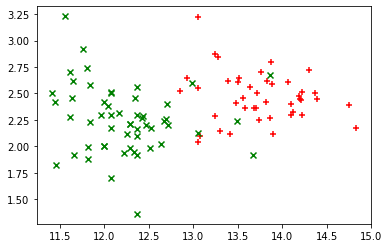

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline

MARKERS = ['+', 'x', '.']
COLORS = ['red', 'green', 'blue']

def plot_points(xy, labels):
    
    for i, label in enumerate(set(labels)):
        points = np.array([xy[j,:] for j in range(len(xy)) if labels[j] == label])
        marker = MARKERS[i % len(MARKERS)]
        color = COLORS[i % len(COLORS)]
        plt.scatter(points[:,0], points[:,1], marker=marker, color=color)

plot_points(X_train, y_train)

# Logistic Regression (LR)
- A probabilistic model for binary classification
- Learns the PMF of the output label given the input, i.e., $p(y \mid x)$
- A discriminative model: Does not model inputs $x$ (only relationship b/w $\boldsymbol{x}$ and $y$ )
- **Uses the sigmoid function to define the conditional probability of $y$ being 1**
- Here $\boldsymbol{w}^{\top} \boldsymbol{x}$ is the score for input $\boldsymbol{x}$. The sigmoid turns it into a probability
![](sigmoid.png)

In logistic regression, the score for an input $\boldsymbol{x}$ is given by the dot product $\boldsymbol{w}^{\top} \boldsymbol{x}$, where $\boldsymbol{w}$ is a vector of weights. This dot product produces a real-valued number, which can be positive or negative. 

The sigmoid function is then used to transform this score into a probability between 0 and 1. Specifically, the sigmoid function takes the form:

$$
\sigma(z) = \frac{1}{1 + e^{-z}},
$$

where $z = \boldsymbol{w}^{\top} \boldsymbol{x}$ is the score for input $\boldsymbol{x}$. The sigmoid function maps any real number to a probability value between 0 and 1, so we can interpret the output of the sigmoid function as the probability of the input belonging to a particular class (e.g., 0 or 1). 

In logistic regression, we use the sigmoid function to model the probability that a given input $\boldsymbol{x}$ belongs to a particular class. If the sigmoid output is greater than 0.5, we predict that the input belongs to the positive class (i.e., it has label 1), and if the sigmoid output is less than 0.5, we predict that the input belongs to the negative class (i.e., it has label 0).

# LR: Decision Boundary
- At the decision boundary where both classes are equiprobable
$$
\begin{aligned}
p(y=1 \mid \boldsymbol{x}, \boldsymbol{w}) & =p(y=0 \mid \boldsymbol{x}, \boldsymbol{w}) \\
\frac{\exp \left(\boldsymbol{w}^{\top} \boldsymbol{x}\right)}{1+\exp \left(\boldsymbol{w}^{\top} \boldsymbol{x}\right)} & =\frac{1}{1+\exp \left(\boldsymbol{w}^{\top} \boldsymbol{x}\right)} \\
\exp \left(\boldsymbol{w}^{\top} \boldsymbol{x}\right) & =1 \\
\boldsymbol{w}^{\top} \boldsymbol{x} & =0
\end{aligned}
$$
- Very large positive $\boldsymbol{w}^{\top} \boldsymbol{x}$ means $p(y=1 \mid \boldsymbol{w}, \boldsymbol{x})$ close to 1
- Very large negative $\boldsymbol{w}^{\top} \boldsymbol{x}$ means $p(y=0 \mid \boldsymbol{w}, \boldsymbol{x})$ close to 1
- At decision boundary, $\boldsymbol{w}^{\top} \boldsymbol{x}=0$ implies $p(y=1 \mid \boldsymbol{w}, \boldsymbol{x})=p(y=0 \mid \boldsymbol{w}, \boldsymbol{x})=0.5$

![](boundary.png)

# MLE for Logistic Regression
Assumed $0 / 1$, not $-1 /+1$
- Likelihood (PMF of each input's label) is Bernoulli with prob $\mu_n=\frac{\exp \left(w^{\top} x_n\right)}{1+\exp \left(w^{\top} x_n\right)}$
$$
p\left(y_n \mid \boldsymbol{w}, \boldsymbol{x}_n\right)=\operatorname{Bernoulli}\left(\mu_n\right)=\mu_n^{y_n}\left(1-\mu_n\right)^{1-y_n}
$$
- Overall likelihood, assuming i.i.d. observations
$$
p(\boldsymbol{y} \mid \boldsymbol{w}, \boldsymbol{X})=\prod_{n=1}^N p\left(y_n \mid \boldsymbol{w}, \boldsymbol{x}_n\right)=\prod_{n=1}^N \mu_n^{y_n}\left(1-\mu_n\right)^{1-y_n}
$$
- The negative log-likelihood $N L L(\boldsymbol{w})=-\log p(\boldsymbol{y} \mid \boldsymbol{w}, \boldsymbol{X})$ simplifies to
"cross-entropy" loss (a popular loss
$$
\text { Loss function } \quad N L L(\boldsymbol{w})=\sum_{n=1}^N-\left[y_n \log \mu_n+\left(1-y_n\right) \log \left(1-\mu_n\right)\right]
$$
Very large loss if $y_n$ close to 1 and
- Plugging in $\mu_n=\frac{\exp \left(w^{\top} x_n\right)}{1+\exp \left(w^{\top} x_n\right)}$ and simplifying

$\mu_n$ close to 0 , or vice-versa
$$
NLL(\boldsymbol{w})=-\sum_{n=1}^N\left[y_n \boldsymbol{w}^{\top} \boldsymbol{x}_n-\log \left(1+\exp \left(\boldsymbol{w}^{\top} \boldsymbol{x}_n\right)\right)\right]
$$

Good news: For LR, NLL is convex

# An Alternate Notation
- If we assume the label $y_n$ as $-1 /+1$ (not $\left.0 / 1\right)$, the likelihood can be written as
$$
p\left(y_n \mid \boldsymbol{w}, \boldsymbol{x}_n\right)=\frac{1}{1+\exp \left(-y_n \boldsymbol{w}^{\top} \boldsymbol{x}_n\right)}=\sigma\left(y_n \boldsymbol{w}^{\top} \boldsymbol{x}_n\right)
$$
- Slightly more convenient notation: A single expression gives the probabilities of both possible label values
- In this case, the total negative log-likelihood will be
$$
N L L(\boldsymbol{w})=\sum_{n=1}^N-\log p\left(y_n \mid \boldsymbol{w}, \boldsymbol{x}_n\right)=\sum_{n=1}^N \log \left(1+\exp \left(-y_n \boldsymbol{w}^{\top} \boldsymbol{x}_n\right)\right)
$$

There's a fairly obvious area near the center of the plot where a line could divide the two colors of points with a small amount of error.

# Simple Logistic Regression

To implement logistic regression, we need a hypothesis function <span class="burk">$h_\theta(x)$</span>, a cost function <span class="girk">$J(\theta)$</span>, and a gradient function that computes the partial derivatives of <span class="mark">$J(\theta)$</span>.

In logistic regression, $h_\theta$ is the [sigmoid](https://www.quora.com/Logistic-Regression-Why-sigmoid-function) function.  The sigmoid function is bounded between 0 and 1, and produces a value that can be interpreted as a probability.  This value can also be a yes / no answer with a cross-over, or decision boundary, at 0.5:

$$
h_\theta(x) = \frac{1}{1 + e^{ \theta^Tx}}
$$

Using [mean squared error](https://en.wikipedia.org/wiki/Mean_squared_error) from linear regression isn't a good idea here, as the resulting cost function [isn't convex](http://mathworld.wolfram.com/SigmoidFunction.html) and so is not well-suited for gradient descent.  Instead, the difference of $h_\theta(x^i) - y^i$ is calculated differently for $y=0$ and $y=1$, and the result is [transformed](https://stackoverflow.com/questions/32986123/why-the-cost-function-of-logistic-regression-has-a-logarithmic-expression) [logarithmically](https://math.stackexchange.com/questions/886555/deriving-cost-function-using-mle-why-use-log-function) into a convex function: 

$$
J(\theta) =-\frac{1}{m}\sum_{i=1}^{m}y^{i}\log(h_\theta(x^{i}))+(1-y^{i})\log(1-h_\theta(x^{i}))
$$

Fortunately, the [derivative](https://math.stackexchange.com/questions/477207/derivative-of-cost-function-for-logistic-regression) of this function is exactly the same as that of linear regression, just with a different $h_\theta(x)$:

$$
\frac{\partial}{\partial\theta_{j}}J(\theta) =\sum_{i=1}^{m}(h_\theta(x^{i})-y^i)x_j^i
$$

In [12]:
import numpy as np

def sigmoid(X):
    return 1 / (1 + np.exp(-X))

def cost(theta, X, y):
    theta = theta[:,None]
    y = y[:,None]
    
    hyp = sigmoid(X.dot(theta))
    pos = np.multiply(-y, np.log(hyp))
    neg = np.multiply((1 - y), np.log(1 - hyp))
    
    return np.sum(pos - neg) / (len(X))

def gradient(theta, X, y):
    theta = theta[:,None]
    y = y[:,None]
    
    error = sigmoid(X.dot(theta)) - y
    return X.T.dot(error) / len(X)

It's worth noting the treatment of `y` and `theta` above.  In each function, I explicitly convert each to an $n$ or $m \times 1$ `ndarray`, so the matrix operations work correctly.  An alternative is to use a numpy `matrix`, which has stricter linear algebra semantics and treats 1-dimensional matrices more like column vectors.  However, I found that it was awkward to get the matrix interface to work correctly with both the optimization function used below, and with TensorFlow.  The indexing syntax can be thought of as explicitly columnizing the array of parameters or labels.

Instead of manually writing a gradient descent, I use an optimization algorithm from Scipy called [`fmin_tnc`](https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.optimize.fmin_tnc.html) to perform it.  This function takes as parameters the cost function, an initial set of parameters for $\theta$, the gradient function, and a tuple of args to pass to each.  I define a `train` function that prepends a columns of 1s to the training data (allowing for a bias parameter $\theta_0$), run the minimization function and return the first of its return values, final parameters for $\theta$.

In [13]:
from scipy.optimize import fmin_tnc  

def train(X, y):
    X = np.insert(X, 0, np.ones(len(X)), axis=1)
    theta = np.zeros(X.shape[1])
    result = fmin_tnc(func=cost, x0=theta, fprime=gradient, args=(X, y))
    
    return result[0]

theta = train(X_train, y_train)
print('theta: ', theta)

theta:  [64.0660192  -4.32819717 -3.21827659]


# Decision Boundaries and Evaluation


I can evaluate the results of the optimization visually and statistically, but I also need one more function: `predict`, which takes an array of examples `X` and learned parameter values `theta` as inputs and returns the predicted label for each.  Here too, 1s must be prepended to the inputs, and I return an integer value representing whether the result of the `sigmoid` hypothesis function is equal to or greater than 0.5.

To test the results of those predictions, Scikit-learn provides three functions to calculate [accuracy, precision and recall] based on the confusion matrix:

|  | Negative | Positive |
| :---: | :---: | :---: |
| Negative | True Negative (TN) | False Positive (FP) |
| Positive | False Negative (FN) | True Positive (TP) |

$$Accuracy =\frac{T P+T N}{T P+T N+F P+F N}$$

$$
\begin{aligned}
\text { Precision } & =\frac{\text { True Positive }}{\text { True Positive }+\text { False Positive }} \\
& =\frac{\text { True Positive }}{\text { Total Predicted Positive }}
\end{aligned}
$$

$$
\begin{aligned}
\text { Recall } & =\frac{\text { True } \text { Positive }}{\text { True Positive }+\text { False Negative }} \\
& =\frac{\text { True Positive }}{\text { Total Actual Positive }}
\end{aligned}
$$

$$
\mathrm{F} 1=2 \times \frac{\text { Precision } * \text { Recall }}{\text { Precision }+\text { Recall }}
$$

F1 Score might be a better measure to use if we need to seek a balance between Precision and Recall AND there is an uneven class distribution (large number of Actual Negatives).

The test data from earlier is used here, so the results represent the performance of the classifier on unseen data.

In [14]:
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix
def predict(X, theta):
    X = np.insert(X, 0, np.ones(len(X)), axis=1)
    return (sigmoid(X * np.matrix(theta).T) >= 0.5).astype(int)

predictions = predict(X_test, theta)
print(confusion_matrix(y_test, predictions))

print('accuracy:', accuracy_score(y_test, predictions))
print('precision:', precision_score(y_test, predictions, average='macro'))
print('recall:', recall_score(y_test, predictions, average='macro'))

[[14  2]
 [ 1 16]]
accuracy: 0.9090909090909091
precision: 0.9111111111111111
recall: 0.9080882352941176


sklearn.metrics.f1_score(y_true, y_pred, *, labels=None, pos_label=1, average='binary', sample_weight=None, zero_division='warn')[source]¶

Compute the F1 score, also known as balanced F-score or F-measure.

The F1 score can be interpreted as a harmonic mean of the precision and recall, where an F1 score reaches its best value at 1 and worst score at 0. The relative contribution of precision and recall to the F1 score are equal. The formula for the F1 score is:

F1 = 2 * (precision * recall) / (precision + recall)
In the multi-class and multi-label case, this is the average of the F1 score of each class with weighting depending on the average parameter.

https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html



In [15]:
from sklearn.metrics import f1_score
print(f1_score(y_test, predictions, average='macro'))
print(f1_score(y_test, predictions, average='micro'))
print(f1_score(y_test, predictions, average=None))


0.9087557603686636
0.9090909090909091
[0.90322581 0.91428571]


In [16]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

# Use the fitted pipeline to make predictions on the validation dataset

print(confusion_matrix(y_test, predictions))
print(classification_report(y_test, predictions))
print("Accuracy (validation):", accuracy_score(y_test, predictions))

[[14  2]
 [ 1 16]]
              precision    recall  f1-score   support

           0       0.93      0.88      0.90        16
           1       0.89      0.94      0.91        17

    accuracy                           0.91        33
   macro avg       0.91      0.91      0.91        33
weighted avg       0.91      0.91      0.91        33

Accuracy (validation): 0.9090909090909091


It's much more interesting to review the results visually, at least while the number of features is limited to two.  To do this, I need to plot the input points again, then overlay the decision boundary on top.  I tried several approaches for this in Matplotlib, and found that an unfilled countour plot gave me the best results.  This can also be done by manually calculating the function to plot, or using a filled contour plot that shades over the actual areas, but doing the math by hand is tedious, and the colormaps for filled contour plots leave a lot to be desired visually.

Below, I define a function `plot_boundary` that takes $n \times 2$ matrix of feature values $(x_0, x_1)$ and a prediction function, then builds a mesh grid of $(x, y)$ points corresponding to possible $(x_0, x_1)$ values within the input range.  After running the prediction function on all of them, the result is an $(x, y, z)$ point in space.  Because the result isn't continuous and flips directly from 0 to 1, there's only one contour that can be drawn on the plot: the decision boundary.

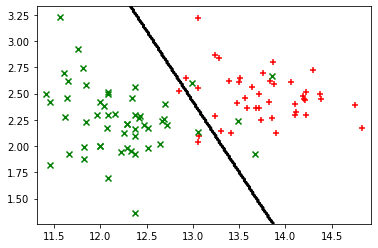

In [17]:
from matplotlib import cm
import numpy as np

def plot_boundary(X, pred):
    
    x_min, x_max = X[:,0].min() - .1, X[:,0].max() + .1
    y_min, y_max = X[:,1].min() - .1, X[:,1].max() + .1
    
    xs, ys = np.meshgrid(
        np.linspace(x_min, x_max, 200),
        np.linspace(y_min, y_max, 200)
    )

    xys = np.column_stack([xs.ravel(), ys.ravel()])
    zs = pred(xys).reshape(xs.shape)

    plt.contour(xs, ys, zs, colors='black')
        
plot_points(X_train, y_train)
plot_boundary(X_train, lambda x: predict(x, theta))

# Multinomial Logistic Regression

With the basics working, the next step is something more interesting: a similar set of two features from the data set (this time alcohol and flavanoids), but with all three labels instead of two.  The only differences below in loading the data are that I no longer filter out rows with the third label, that I use the full output from `label_binarize`, resulting in an $m \times 3$ array for `y`.

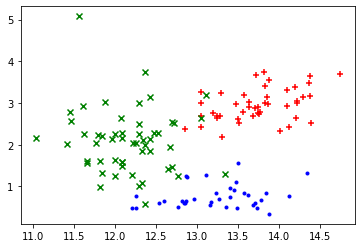

In [18]:
X = data[['alcohol', 'flavanoids']].values
y = data[['class']].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)
y_train = label_binarize(y_train, classes=[1, 2, 3])

plot_points(X_train, y_train.argmax(axis=1))

The plotted data points again suggest some obvious linear boundaries between the wines.

It turns out that solving this as three one-vs-all problems is trivial, and re-uses all the code I just wrote.  Instead of one array of `theta` values I train three, one per problem, and then define a new `predict_multi` function that computes the three sigmoids for each example using each array of `theta` parameters.  This time, rather than return `1` or `0` based on whether the value is above or below 0.5, I return the `argmax` of each resulting row, the index of the largest value.

accuracy: 0.8222222222222222
precision: 0.8312908496732025
recall: 0.8323158323158323


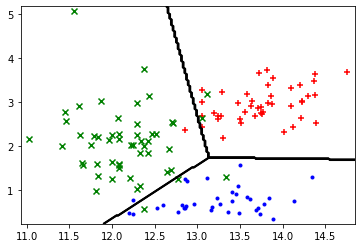

In [19]:
def predict_multi(X, thetas):
    X = np.insert(X, 0, np.ones(len(X)), axis=1)
    preds = [sigmoid(X * np.asmatrix(t).T) for t in thetas]
    return np.column_stack(preds).argmax(axis=1)

thetas = [train(X_train, y_train[:,i]) for i in range(0,3)]
predictions = predict_multi(X_test, thetas) + 1

print('accuracy:', accuracy_score(y_test, predictions))
print('precision:', precision_score(y_test, predictions, average='macro'))
print('recall:', recall_score(y_test, predictions, average='macro'))

plot_points(X_train, y_train.argmax(axis=1))
plot_boundary(X_train, lambda x: predict_multi(x, thetas))

Looking at the plot above, it seems like the boundaries could be much more accurate if they didn't have to be straight lines.  To allow for this, I define a function `transform` to add some polynomial features, converting each input example of $(x_0, x_1)$ to $(x_0, x_1, x_2, x_3, x_4)$, where $x_2 = x_0^2$, $x_3 = x_1^2$ and $x_4 = x_0x_1$.

accuracy: 0.8222222222222222
precision: 0.8474945533769063
recall: 0.8251933251933252


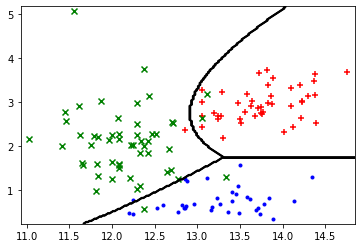

In [20]:
def transform_x(x):
    return [x[0], x[1], x[0] ** 2, x[1] ** 2, x[0] * x[1]]

def transform(X):
    return np.apply_along_axis(transform_x, 1, X)

X_train = transform(X_train)
X_test = transform(X_test)

thetas = [train(X_train, y_train[:,i]) for i in range(0,3)]
predictions = predict_multi(X_test, thetas) + 1

print('accuracy:', accuracy_score(y_test, predictions))
print('precision:', precision_score(y_test, predictions, average='macro'))
print('recall:', recall_score(y_test, predictions, average='macro'))

plot_points(X_train, y_train.argmax(axis=1))
plot_boundary(X_train, lambda x: predict_multi(transform(x), thetas))

# Regularization

Next, I want to include all the features from the data set.  To do this, instead of specifying what columns I want to include, I use `drop` to include everything except the `class` column.

Because I'm now significantly increasing the number of features, I apply [regularization](https://www.quora.com/What-is-regularization-in-machine-learning) as part of new cost and gradient functions.  Regularization prevents overfitting, a situation where a large number of features allows the classifier to fit the training set *too* exactly, meaning that it fails to generalize well and perform accurately on data it hasn't yet seen.

To avoid this problem, I add an additional term to the cost function and its gradient, representing the aggregated weights of each $\theta$ parameter.  Adding this term effectively increases the cost, meaning that the overall impact of feature weights is muted, and the fit to the training set is softened.  Note that for each of the new cost and gradient functions, the summation for regularization starts at $j = 1$, since the constant bia parameter $\theta_0$ is typically not regularized:

$$
J(\theta) =-\frac{1}{m}\sum_{i=1}^{m}[y^{i}\log(h_\theta(x^{i}))+(1-y^{i})\log(1-h_\theta(x^{i}))] + \frac{\lambda}{2m}\sum_{j=1}^{n}\theta_j^2 \\
\frac{\partial}{\partial\theta_{j}}J(\theta) =\sum_{i=1}^{m}(h_\theta(x^{i})-y^i)x_j^i + \frac{\lambda}{m}\theta_j
$$

Below, I define the new cost and gradient functions, as well as a new function to train the classifier, given the addition of a new parameter `l`, for $\lambda$.  This parameter can be adjusted to change the effect of regularization; here I'm just using `1.0`.  In each case, I ensure that $\theta_0$ isn't regularized by creating a temporary `theta_reg`, starting with a zero followed by elements one and onward from `theta`.

In [21]:
X = data.drop('class', 1).values
y = data[['class']].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)
y_train = label_binarize(y_train, classes = [1, 2, 3])

def cost_reg(theta, X, y, lambda_):
    theta_reg = np.array((0, *theta[1:]))[:,None]
    reg = lambda_ * np.square(theta_reg).sum() / (2 * len(X))
    
    return cost(theta, X, y) + reg

def gradient_reg(theta, X, y, lambda_):
    theta_reg = np.array((0, *theta[1:]))[:,None]
    reg = lambda_ * theta_reg / len(X)
    
    return gradient(theta, X, y) + reg

def train_reg(X, y, lambda_):
    X = np.insert(X, 0, np.ones(len(X)), axis=1)
    theta = np.zeros(X.shape[1])
    result = fmin_tnc(func=cost_reg, x0=theta, fprime=gradient_reg, args=(X, y, lambda_))
    
    return result[0]

thetas = [train_reg(X_train, y_train[:,i], 1.0) for i in range(0,3)]
predictions = predict_multi(X_test, thetas) + 1

print('accuracy:', accuracy_score(y_test, predictions))
print('precision:', precision_score(y_test, predictions, average='macro'))
print('recall:', recall_score(y_test, predictions, average='macro'))

accuracy: 0.9333333333333333
precision: 0.9269841269841269
recall: 0.9363636363636364


# Logistic Regression with TensorFlow

In this last section, I implement logistic regression using TensorFlow and test the model using the same data set.  TensorFlow allows for a significantly more compact and higher-level representation of the problem as a computational graph, resulting in less code and faster development of models.

One item definitely worth calling out is the use of the [`AdamOptimizer`](https://www.tensorflow.org/api_docs/python/tf/train/AdamOptimizer) instead of the [`GradientDescentOptimizer`](https://www.tensorflow.org/api_docs/python/tf/train/GradientDescentOptimizer) from the previous post.  Although the latter can still be used here, I found it a poor fit for two reasons:  it is *very* sensitive to learning rate and lambda parameters, and it converges extremely slowly.  Correct convergence required a very low learning rate (around 0.001 at most), and could still be seen decreasing at over 300,000 iterations, with a curve that appeared linear after the first thousand.  Poor tuning resulted in the optimizer spinning out of control and emitting `nan` values for all the parameters.

Using a different optimizer helped tremendously, especially one that is [adaptive](https://stackoverflow.com/questions/33919948/how-to-set-adaptive-learning-rate-for-gradientdescentoptimizer).  It converges significantly faster and requires much less hand-holding to do so.  Even then, these graphs take typically 25x the time to converge properly compared to the manual implementation above, and I'm not sure why this is the case.  Since Tensorflow does the calculus itself to find the gradient, it could be that this is the result of some issue or lack of optimization.  On the other hand, given that the platform is designed to distribute computations and scale to significantly larger data sets, this could be some overhead that is quite reasonable in those scenarios but is felt heavily in a small demonstration with a tiny number of examples.

I also adjusted all placeholders and variables to `tf.float64`, to avoid any issues with numerical precision.  After this and the adaptive optimizer, the results improved dramatically.

Because I want to build a few different graphs, I define a function that builds one given a few parameters: the number of features, the number of labels, and a lambda value for regularization.  This function `tf_create` builds a graph, and returns two functions itself: one to train the algorithm by running the optimizer, and another to predict labels for new values.  To compute the loss for regularization, I use the built-in `tf.nn.l2_loss` function, which is equivalent to the regularization loss I computed manually before.

In [24]:
import tensorflow as tf
import tensorflow.compat.v1 as v1
tf.compat.v1.disable_eager_execution()

def tf_create(n_features, n_labels, lambda_):
    
    examples = v1.placeholder(v1.float64, [None, n_features])
    labels = v1.placeholder(v1.float64, [None, n_labels])
    weights = v1.Variable(v1.zeros([n_features, n_labels], dtype=v1.float64))
    bias = v1.Variable(v1.zeros([n_labels], dtype=tf.float64))
    
    hyp = v1.sigmoid(v1.matmul(examples, weights) + bias)
    loss = v1.reduce_mean(-labels * v1.log(hyp) - (1 - labels) * v1.log(1 - hyp))
    reg = lambda_ * v1.nn.l2_loss(weights)
    cost = loss + reg
    
    train = v1.train.AdamOptimizer().minimize(cost)
    predict = v1.argmax(hyp, axis=1)
    
    def train_(sess, X, y, iterations):
        for i in range(iterations):
            sess.run(train, feed_dict={examples: X, labels: y})
            
    def predict_(sess, X):
        return sess.run(predict, feed_dict={examples: X})
    
    return train_, predict_

First, I evaluate the model against the 2-feature, 3-label example from above.

accuracy: 0.9111111111111111
precision: 0.9129210658622423
recall: 0.9155354449472096


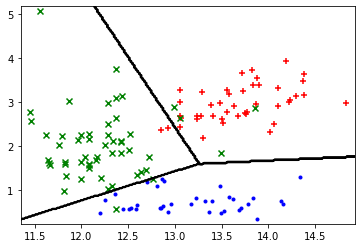

In [26]:
X = data[['alcohol', 'flavanoids']].values
y = label_binarize(data[['class']], classes = [1, 2, 3])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)


with v1.Session() as sess:
    
    train, predict = tf_create(X.shape[1], y.shape[1], 0.0)
    sess.run(v1.global_variables_initializer())
    train(sess, X_train, y_train, 30000)

    predictions = predict(sess, X_test)
    y_test = y_test.argmax(axis=1)

    print('accuracy:', accuracy_score(y_test, predictions))
    print('precision:', precision_score(y_test, predictions, average='macro'))
    print('recall:', recall_score(y_test, predictions, average='macro'))

    plot_boundary(X_train, lambda x: predict(sess, x))
    plot_points(X_train, y_train.argmax(axis=1))

Next, I use the `transform` function to apply additional polynomial features to the dataset, allowing for a non-linear decision boundary.

accuracy: 0.8666666666666667
precision: 0.8662698412698413
recall: 0.8764753764753767


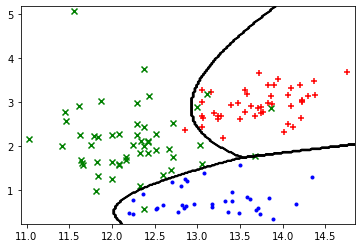

In [28]:
X = data[['alcohol', 'flavanoids']].values
X = transform(X)
y = label_binarize(data[['class']], classes=[1, 2, 3])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

with v1.Session() as sess:
    
    train, predict = tf_create(X.shape[1], y.shape[1], 0.0)
    sess.run(v1.global_variables_initializer())
    train(sess, X_train, y_train, 30000)

    predictions = predict(sess, X_test)
    y_test = y_test.argmax(axis=1)

    print('accuracy:', accuracy_score(y_test, predictions))
    print('precision:', precision_score(y_test, predictions, average='macro'))
    print('recall:', recall_score(y_test, predictions, average='macro'))

    plot_boundary(X_train, lambda x: predict(sess, transform(x)))
    plot_points(X_train, y_train.argmax(axis=1))

Finally, I include all the features from the data set, all the labels, and apply a small amount of regularization.

In [31]:
X = data.drop('class', 1).values
y = label_binarize(data[['class']], classes=[1, 2, 3])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

with v1.Session() as sess:
    
    train, predict = tf_create(X.shape[1], y.shape[1], 0.1)
    sess.run(v1.global_variables_initializer())
    train(sess, X_train, y_train, 30000)

    predictions = predict(sess, X_test)
    y_test = y_test.argmax(axis=1)

    print('accuracy:', accuracy_score(y_test, predictions))
    print('precision:', precision_score(y_test, predictions, average='macro'))
    print('recall:', recall_score(y_test, predictions, average='macro'))

C:\Users\enh\AppData\Local\Temp\ipykernel_27488\2050926482.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  X = data.drop('class', 1).values


accuracy: 0.8888888888888888
precision: 0.927536231884058
recall: 0.8772893772893773


You can find the IPython notebook for this post on [GitHub](https://github.com/crsmithdev/notebooks/blob/master/ml-logistic-regression/ml-logistic-regression.ipynb).